MS5114 Individual Assignment: ETF Analysis and Forecasting


Step 1: Install Required Libraries

pip install yfinance pyspark prophet pandas matplotlib scikit-learn numpy

* yfinance: Fetches historical financial data from Yahoo Finance.

* pyspark: Processes large datasets.

* prophet: Forecasts time-series data.

* pandas: Manipulates data in tables.

* matplotlib: Creates charts for analysis.

* scikit-learn: Evaluates model performance.

* numpy: Performs numerical operations.

Step 2: Import Libraries

In [12]:
import yfinance as yf  # Fetch historical stock data.
from datetime import datetime, timedelta  # Handle date operations.
import matplotlib.pyplot as plt  # Visualize trends.
import os  # Manage directories.
from pyspark.sql import SparkSession  # Process data using PySpark.
from prophet import Prophet  # Time-series forecasting.
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Evaluate accuracy.
import numpy as np  # Numerical operations.

Step 3: Fetch Historical Data from Yahoo Finance

Dataset fetched: SPDR S&P 500 ETF Trust (SPY)

yf.download: Downloads historical stock data from Yahoo Finance.

reset_index(inplace=True): Adds the date as a regular column; inplace=True modifies the original object.

to_csv(index=False): Saves the data to a CSV file without adding an extra index column.

In [13]:
etf_symbol = "SPY"
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)
etf_data = yf.download(etf_symbol, start=start_date, end=end_date)
etf_data.reset_index(inplace=True)
etf_data.to_csv("ETF_SPY_5years.csv", index=False)
print(etf_data.head())

[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open     Volume
Ticker                    SPY         SPY         SPY         SPY        SPY
0      2020-02-20  312.394623  313.961466  309.362907  313.127031   74163400
1      2020-02-21  309.177429  311.337616  308.342995  311.022398  113788200
2      2020-02-24  298.923492  309.251645  297.829464  299.591023  161088400
3      2020-02-25  289.865448  300.953848  288.975416  300.332691  218913200
4      2020-02-26  288.799316  294.927597  288.057628  291.284004  194773800


Output: Displays the first 5 rows.

Explanation: Data is saved at D:\python\MS5114_Individual assignment.

Step 4: Calculate Moving Averages and Generate Trading Signals

rolling(window=n).mean(): Calculates moving averages.

loc: Assigns signals based on conditions.

In [14]:
short_window = 10  # Define the short-term moving average window (10 days).
# Why: Short-term MAs help identify recent trends and are used for generating buy/sell signals.
long_window = 100  # Define the long-term moving average window (100 days).
# Why: Long-term MAs smooth out longer trends and provide a broader market perspective.

etf_data["Short_MA"] = etf_data["Close"].rolling(window=short_window).mean()  # Calculate the short-term moving average.
# Why: Used to track short-term price movements for trend analysis.
etf_data["Long_MA"] = etf_data["Close"].rolling(window=long_window).mean()  # Calculate the long-term moving average.
# Why: Provides a long-term trend for identifying market directions.
etf_data["Signal"] = 0  # Initialize a column to store trading signals.
# Why: Signals (1 for Buy, -1 for Sell, 0 for No Action) help investors make decisions.
etf_data.loc[etf_data["Short_MA"] > etf_data["Long_MA"], "Signal"] = 1  # Assign a Buy signal when the short-term MA crosses above the long-term MA.
# Why: This indicates a potential upward trend, suggesting a buying opportunity.
etf_data.loc[etf_data["Short_MA"] < etf_data["Long_MA"], "Signal"] = -1  # Assign a Sell signal when the short-term MA crosses below the long-term MA.
# Why: This indicates a potential downward trend, suggesting a selling opportunity.

print("Buy Signals:", (etf_data["Signal"] == 1).sum())
print("Sell Signals:", (etf_data["Signal"] == -1).sum())

Buy Signals: 920
Sell Signals: 236


Output: Buy Signals: 922, Sell Signals: 236.

Explanation: Buy signals occur when the 10-day MA surpasses the 100-day MA.

Step 5: Visualize Stock Prices and Signals

plt.plot: Displays line charts.

plt.legend(): Shows labels for each line.

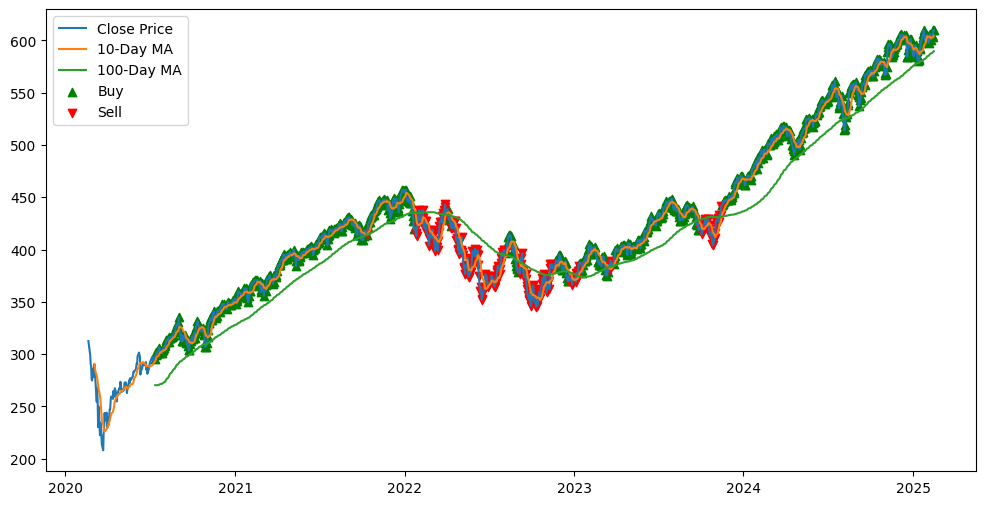

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(etf_data['Date'], etf_data['Close'], label="Close Price")
plt.plot(etf_data['Date'], etf_data['Short_MA'], label="10-Day MA")
plt.plot(etf_data['Date'], etf_data['Long_MA'], label="100-Day MA")
plt.scatter(etf_data['Date'][etf_data['Signal'] == 1], etf_data['Close'][etf_data['Signal'] == 1], label="Buy", marker="^", color="green")
plt.scatter(etf_data['Date'][etf_data['Signal'] == -1], etf_data['Close'][etf_data['Signal'] == -1], label="Sell", marker="v", color="red")
plt.legend()
plt.show()

Output: Graph showing trends with buy/sell markers.

Explanation: Visual representation of trends and trading signals.
Output Explanation: The image shows a line chart with three curves:

Blue Line (Close Price): Represents the daily closing price of the ETF.

Orange Line (10-Day Moving Average): Short-term average that reacts quickly to price changes.

Green Line (100-Day Moving Average): Long-term average that smooths out price trends.

What does this chart indicate?

Trends: The 100-day moving average (green) shows long-term trends, while the 10-day moving average (orange) shows short-term fluctuations.

Crossover Points: Points where the orange line crosses the green line can signal potential buy (upward cross) or sell (downward cross) opportunities.

Market Cycles: The chart shows bullish (upward) and bearish (downward) phases from 2019 to 2024.

Step 6: Prepare Data for Forecasting with Prophet

rename(columns={}): Renames columns.

Prophet requires ds (date) and y (value).

In [ ]:
import os
from pyspark.sql import SparkSession  # This initializes PySpark for distributed data processing.
# Why: Spark handles large datasets efficiently, allowing us to preprocess and prepare data for analysis.

# Set Java path directly (replace this with your actual Java path)
# uncomment below line in case Java is not locatable 
#os.environ["JAVA_HOME"] = r"C:\Program Files\Microsoft\jdk-11.0.26.4-hotspot"
# os.environ["SPARK_HOME"] = r"C:\Users\Raviraj\anaconda3\envs\sparkenv\Lib\site-packages\pyspark"
# os.environ["JAVA_HOME"] = r"C:\Program Files\Microsoft\jdk-11.0.26.4-hotspot"

spark = SparkSession.builder.appName("ETFAnalysis").getOrCreate()
etf_spark_df = spark.createDataFrame(etf_data[["Date", "Close"]])
etf_spark_df = etf_spark_df.withColumnRenamed("Date", "ds").withColumnRenamed("Close", "y")
etf_pandas_df = etf_spark_df.toPandas().dropna()

Output: Displays cleaned DataFrame.

Explanation: Converts data into a Prophet-compatible format.

This is a MultiIndex DataFrame, meaning the data has multiple levels of indexing.

Columns with Tickers (e.g., 'SPY'): Indicates that your data includes multiple stock attributes.

Column Names ('Price', 'Ticker'): Shows hierarchical levels of column labels.

Why did this happen? Your data source (likely yfinance) returned a multi-index table due to how it structures ticker information.

How to Fix: Flatten the multi-index before renaming columns:
etf_data.columns = ['_'.join(col).strip() for col in etf_data.columns]

In [17]:
etf_pandas_df.columns = ['ds', 'y']

Output: Displays a MultiIndex from Yahoo Finance.

MultiIndex([( 'Date', ''), ('Close', 'SPY'), ('High', 'SPY'), ...])

Explanation: Resolves multi-index issues from Yahoo Finance.

etf_data[['Date', 'Close']]: Selects only the necessary columns.

.rename(columns={"Date": "ds", "Close": "y"}): Renames columns to Prophet-compatible names (ds, y).

In [18]:
print(etf_data.columns)


MultiIndex([(    'Date',    ''),
            (   'Close', 'SPY'),
            (    'High', 'SPY'),
            (     'Low', 'SPY'),
            (    'Open', 'SPY'),
            (  'Volume', 'SPY'),
            ('Short_MA',    ''),
            ( 'Long_MA',    ''),
            (  'Signal',    '')],
           names=['Price', 'Ticker'])


Step 7: Forecast Future Prices Using Prophet

Prophet(): Creates a forecasting model.

fit(): Trains the model.

make_future_dataframe(): Generates future dates.

predict(): Produces forecast results.

In [19]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)  # Initialize model
model.fit(etf_pandas_df)  # Train model with historical data
future_dates = model.make_future_dataframe(periods=90)  # Predict next 90 days
forecast = model.predict(future_dates)  # Generate forecast
forecast.to_csv("ETF_SPY_Forecast.csv", index=False)
print(forecast[['ds', 'yhat']].tail())

01:26:18 - cmdstanpy - INFO - Chain [1] start processing
01:26:18 - cmdstanpy - INFO - Chain [1] done processing


             ds        yhat
1340 2025-05-11  669.927359
1341 2025-05-12  636.573010
1342 2025-05-13  636.876060
1343 2025-05-14  637.417697
1344 2025-05-15  638.121218


From above output: This is an informational log generated by cmdstanpy, the backend engine used by Prophet for model fitting.

Chain [1] start processing: Indicates that the first sampling chain for the Bayesian model has started.

Chain [1] done processing: Indicates that the chain has completed its process.

Prophet() initializes the model.

.fit() trains it.

.make_future_dataframe() creates 90 future dates.

.predict() generates predictions.

.tail() displays the last 5 rows of predictions.

Output:

Logs from cmdstanpy: Backend that processes the Bayesian model.

Chain [1]: Indicates the first sampling process for the model.

Step 8: Evaluate Forecast Performance 

mean_absolute_error: Measures average prediction error.

np.sqrt(mean_squared_error): Calculates RMSE.

In [20]:
actual = etf_pandas_df['y'].iloc[-30:]  # Last 30 days actual prices
predicted = forecast['yhat'].iloc[-30:]  # Last 30 days predicted prices
mae = mean_absolute_error(actual, predicted)  # Calculate MAE
rmse = np.sqrt(mean_squared_error(actual, predicted))  # Calculate RMSE
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 45.61, RMSE: 48.73


Step 9: Save Forecast Results to Custom Directory

os.makedirs(): Creates a directory if it doesn’t exist.

to_csv(): Saves results to a CSV file.

In [21]:
save_path = r"D:\\python\\MS5114_Individual assignment"  # Specify path
os.makedirs(save_path, exist_ok=True)  # Create folder if not exists
forecast.to_csv(os.path.join(save_path, "ETF_SPY_Forecast.csv"), index=False)  # Save CSV
print(f"Forecast saved to: {save_path}")

Forecast saved to: D:\\python\\MS5114_Individual assignment


In [ ]:
save_path = r"D:\\python\\MS5114_Individual assignment"  # Specify path
os.makedirs(save_path, exist_ok=True)  # Create folder if not exists
forecast.to_json(os.path.join(save_path, "ETF_SPY_Forecast.json"), index=False)  # Save JSON
print(f"Forecast saved to: {save_path}")

Forecast saved to: D:\\python\\MS5114_Individual assignment
